# 1. Importing Important Python Libraries

In [2]:
%matplotlib inline
%matplotlib widget
import os
import numpy as np
import h5py
# import opencv as cv2
# verify mintpy install
from pathlib import Path
from typing import List, Union
from osgeo import gdal
from osgeo import osr
import numpy as np
from numpy import arange
import mintpy
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix
from mintpy.objects import ifgramStack
from mintpy.utils import readfile, writefile, plot as pp, utils as ut
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.unwrap_error_phase_closure import calc_num_triplet_with_nonzero_integer_ambiguity
from mintpy.view import prep_slice, plot_slice
# from mintpy.objects.insar_vs_gps import plot_insar_vs_gps_scatter
from cartopy import crs as ccrs
from zipfile import ZipFile
from zipfile import BadZipFile
import json
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.dates import DateFormatter
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import math
import urllib
import requests
import datetime
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries
from geopandas import GeoDataFrame
from scipy.optimize import curve_fit
import scipy.optimize as opt
from PIL import Image
import rasterio
import subprocess
from rasterio.plot import show

# Handle date time conversions between pandas and matplotlib

from dateutil.parser import parse as parse_date
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.geometry import shape 
# from descartes import PolygonPatch
from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.models import LabelSet
import ipywidgets as widgets
from ipywidgets import Layout

# utils function
def configure_template_file(outName, CONFIG_TXT): 
    """Write configuration files for MintPy to process HyP3 product"""
    if os.path.isfile(outName):
        with open(outName, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(outName))

    else:
        with open(outName, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(outName))

# 2. Defining project and required directories

In [3]:
proj_name = 'Old_Little_Belt_Bridge'
proj_dir = Path('/mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1')
hyp3_dir = Path('/mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/data')
work_dir = Path('/mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output')
plot_dir = Path('/mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/plots')

In [45]:
pwd

'/mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1'

# 3. Subsetting Data 
This can be done through user defined coordinated or the analysis can be run through common overlap area

## 3.1. To subset data (clip) with user defined coordinates
To reproject add dstSRS='EPSG:32646' to gdal.Wrap(), adjust EPSG code according to requirement or let use as it is

In [14]:
files = hyp3_dir.rglob('*.tif')
files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', 
                    '_lv_theta.tif', '_lv_phi.tif']

for extension in files_for_mintpy:
    for file in hyp3_dir.rglob(f'*{extension}'):
        dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'
        #dst_file.unlink()
        #gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)
        gdal.Warp(destNameOrDestDS=str(dst_file), srcDSOrSrcDSTab=str(file),
                  outputBounds=[9.689270,  55.507066, 9.731802, 55.526069], # [W,S,E,N]
                  outputBoundsSRS='EPSG:4326', dstSRS='EPSG:4326')
     
        # Delete the original file after clipping
        file.unlink()

## 3.2. Subsetting Data to Common Overlap

In [ ]:
def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files
    
    Arg:
        file_list: a list of GeoTIFF files
    
    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """
    
    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]

In [ ]:
files = hyp3_dir.glob('*/*_dem.tif')

overlap = get_common_overlap(files)

In [ ]:
def clip_hyp3_products_to_common_overlap(hyp3_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        hyp3_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """

    
    files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']

    for extension in files_for_mintpy:

        for file in hyp3_dir.rglob(f'*{extension}'):

            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'

            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)


In [ ]:
clip_hyp3_products_to_common_overlap(hyp3_dir, overlap)

# 4. Configuring `smallbaselineApp.py` processing parameters

The processing parameters for the smallbaselineApp.py are controlled through a configuration file. If no file is provided the default smallbaselineApp.cfg configuration is used. We will create a custom config file with modified configuration parameters for this time-series analysis. Any options added to the custom config will override options set in the default config.

In [25]:
CONFIG_TXT = f'''# vim: set filetype=cfg:
########## computing resource configuration
mintpy.compute.maxMemory = 12 #[float > 0.0], auto for 4, max memory to allocate in GB
## parallel processing with dask
## currently apply to steps: invert_network, correct_topography
## cluster   = none to turn off the parallel computing
## numWorker = all  to use all of locally available cores (for cluster = local only)
## numWorker = 80%  to use 80% of locally available cores (for cluster = local only)
## config    = none to rollback to the default name (same as the cluster type; for cluster != local)
mintpy.compute.cluster   = auto #[local / slurm / pbs / lsf / none], auto for none, cluster type
mintpy.compute.numWorker = auto #[int > 1 / all / num%], auto for 4 (local) or 40 (slurm / pbs / lsf), num of workers
mintpy.compute.config    = auto #[none / slurm / pbs / lsf ], auto for none (same as cluster), config name

mintpy.load.processor         = hyp3
mintpy.compute.maxMemory = auto #[float > 0.0], auto for 4, max memory to allocate in GB
ORBIT_DIRECTION = descending
##---------interferogram datasets:
mintpy.load.unwFile          = {hyp3_dir}/*/*unw_phase_clipped.tif
mintpy.load.corFile          = {hyp3_dir}/*/*corr_clipped.tif
##---------geometry datasets:
mintpy.load.demFile          = {hyp3_dir}/*/*dem_clipped.tif
mintpy.load.incAngleFile     = {hyp3_dir}/*/*lv_theta_clipped.tif
mintpy.load.azAngleFile      = {hyp3_dir}/*/*lv_phi_clipped.tif
mintpy.load.waterMaskFile    = {hyp3_dir}/*/*water_mask_clipped.tif
# mintpy.load.connCompFile     = {hyp3_dir}/*/*conncomp_clipped.tif
mintpy.reference.lalo        = auto #[31.8,130.8 / auto] #[N,E]
mintpy.reference.date        = 20210106  #[reference_date.txt / 20090214 / no], auto for reference_date.txt
mintpy.solidEarthTides       = yes    #[yes / no], auto for no
mintpy.troposphericDelay.method = height_correlation
mintpy.deramp                = quadratic    #[no / linear / quadratic], auto for no - no ramp will be removed
mintpy.save.hdfEos5          = yes     #[yes / no], auto for no, save time-series to HDF-EOS5 format
mintpy.plot.dpi              = 400  #[int], auto for 150, number of dots per inch (DPI)
mintpy.geocode.laloStep      = auto  #[-0.000555556,0.000555556 / None], auto for None, output resolution in degree
mintpy.unwrapError.method    = auto  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
mintpy.networkInversion.minTempCoh  = 0.4 #[0.0-1.0], auto for 0.7, min temporal coherence for mask
'''
print(CONFIG_TXT)
configName = os.path.join(work_dir, "{}.txt".format(proj_name))
configure_template_file(configName, CONFIG_TXT)

# vim: set filetype=cfg:
########## computing resource configuration
mintpy.compute.maxMemory = 12 #[float > 0.0], auto for 4, max memory to allocate in GB
## parallel processing with dask
## currently apply to steps: invert_network, correct_topography
## cluster   = none to turn off the parallel computing
## numWorker = all  to use all of locally available cores (for cluster = local only)
## numWorker = 80%  to use 80% of locally available cores (for cluster = local only)
## config    = none to rollback to the default name (same as the cluster type; for cluster != local)
mintpy.compute.cluster   = auto #[local / slurm / pbs / lsf / none], auto for none, cluster type
mintpy.compute.numWorker = auto #[int > 1 / all / num%], auto for 4 (local) or 40 (slurm / pbs / lsf), num of workers
mintpy.compute.config    = auto #[none / slurm / pbs / lsf ], auto for none (same as cluster), config name

mintpy.load.processor         = hyp3
mintpy.compute.maxMemory = auto #[float > 0.0], auto for 4, m

# 5. Small Baseline Time Series Analysis

**We can run every step in smallbaselineApp.py with one call, using the command in the cell below**

We will run the steps:
- load_data
- modify_network
- reference_point
- quick_overview
- invert_network
- correct_troposphere
- correct_topography
- residual_RMS
- reference_date
- velocity
- google_earth

Skipped steps include:
- correct_unwrap_error
- correct_LOD
- correct_SET
- deramp
- hdfeos5

Skipped steps will also be skipped if running the entire smallbaselineApp in the cell below.

In [ ]:
# This runs every step

#! smallbaselineApp.py --work-dir {work_dir} {configName} 

## 5.1. Load Data

**Run the `load_data` step**

In [16]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep load_data

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 08:55:49.779887--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
copy default template file /home/asmit/miniconda3/envs/mintpy/lib/python3.11/site-packages/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
    mintpy.compu

## 5.2. Modify the Network

**Run the `modify_network` step**

- Identifies and excludes interferograms (i.e. affected by remaining coherence phase-unwrapping errors) before the network inversion

In [17]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep modify_network

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 09:09:12.219216--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for back

## 5.3. Plot the interferogram network

Running **plot_network.py** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- `ifgramStack_coherence_spatialAvg.txt`: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- `Network.pdf`: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms. 
- `CoherenceMatrix.pdf` shows the avergae coherence pairs between all available pairs in the stack.

read options from template file: mintpy_config.txt
read temporal/spatial baseline info from file: ./output/inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
calculating spatial mean of coherence in file ./output/inputs/ifgramStack.h5 ...
[==================================================] 609/609   57s /     1s 
write average value in space into text file: coherenceSpatialAvg.txt
number of acquisitions: 154
number of interferograms: 609
shift all perp baseline by -76.0315170288086 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 609
number of acquisitions marked as drop: 0
max perpendicular baseline: 347.43 m
max temporal      baseline: 36.0 days
showing coherence
data range: [0.3498, 0.6193]
display range: (0.2, 1.0)
showing ...


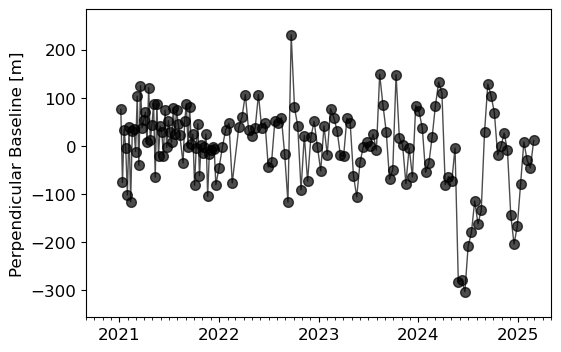

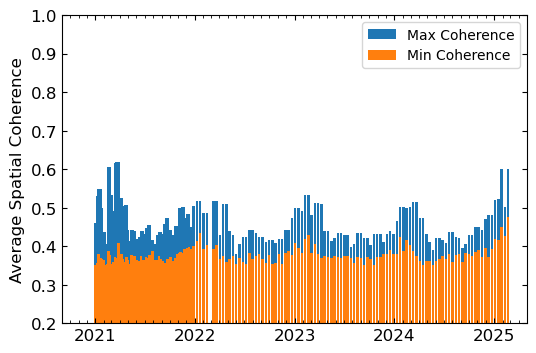

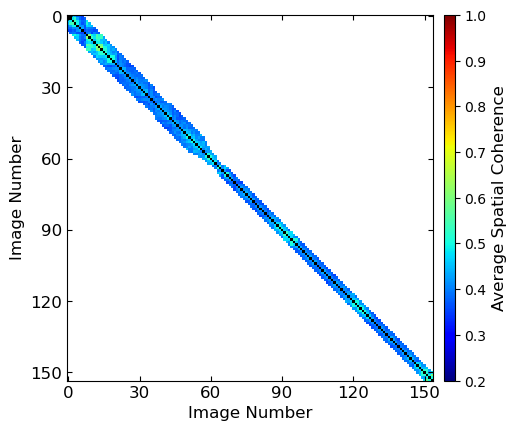

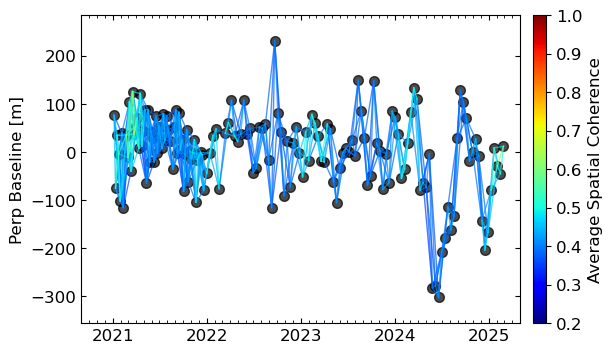

In [18]:
%matplotlib inline
plot_network.main('./output/inputs/ifgramStack.h5 -t ./output/mintpy_config.txt -d coherence --show-kept --notitle --mc black --ms 7 --fs 6 --lw 1 -c jet --figsize 6 4'.split())

## 5.4. Set the Reference Point

**Run the `reference_point` step**

The interferometric phase is a relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore, we need to reference all interferograms to a common reference pixel.

The `reference_point` step selects a common reference pixel for the stack of interferograms. The default approach of MintPy is to choose a pixel with the highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel.   

In [19]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep reference_point

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 09:13:46.093985--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbase

**Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the `ifgramStack.h5` file. To see the attributes of the file run `info.py`**

In [20]:
! info.py ./output/inputs/ifgramStack.h5 | egrep 'REF_'

  REF_LAT                               55.521996928571426
  REF_LON                               9.721977356725146
  REF_X                                 131
  REF_Y                                 16


## 5.5. Run a Quick Overview

**Run the `quick_overview` step**

- Assess possible groud deformation using the velocity from traditional interferogram stacking 
    - *reference: Zebker et al. (1997, JGR)*
- Assess distribution of phase unwrapping error from the number of interferogram triplets with non-zero integer ambiguity of closure phase 
    - *reference: T_int in Yunjun et al. (2019, CAGEO). Related to section 3.2, equation (8-9) and Fig. 3d-e.*

In [26]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep quick_overview

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:47:25.278473--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['quick_overview']
Remaining steps: ['correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
    mintpy.networkInversion.minTempCoh: 0.5 --> 0.4
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_Little_Belt_Bridge.

## 5.6. Inverting the Small Baseline network

**Run the `invert_network` step**

- Invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date
- By default mintpy selects the first acquisition
- The estimated time-series is converted to distance change from radar to target and is provided in meters. 

In [27]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep invert_network

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:47:35.484779--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_

## 5.7. Correcting Solid Earth Tides (SET) Errors

**Run the `correct_SET` step**

In [28]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep correct_SET

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:47:46.148900--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['correct_SET']
Remaining steps: ['correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_Little_Belt_Bridge.txt to pic    

In [29]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep correct_unwrap_error

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:48:14.043859--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['correct_unwrap_error']
Remaining steps: ['invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directo

## 5.8. Correct for Tropospheric Propagation Delays (Optional)

**Run the `correct_troposphere` step**

- Uses ECMWF [ERA5 climate reanalysis pressure data](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&keywords=((%20%22Product%20type:%20Reanalysis%22%20)%20AND%20(%20%22Provider:%20Copernicus%20C3S%22%20))&text=pressure)
- CDS limits ECMWF archive requests to 50, so your requests may be queued until there is space.
    - https://cds.climate.copernicus.eu/live/queue

In [30]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep correct_troposphere

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:48:20.402157--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['correct_troposphere']
Remaining steps: ['deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_Little_Belt_Bridge.txt to pic      directory for backup.
copy smallbas

## 5.9. Removing Phase Ramp

**Run the `deramp` step**
- Estimate and remove a phase ramp for each acquisition based on the reliable pixels.

In [31]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep deramp

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:48:27.786094--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_Little_Belt_Bridge.txt to pic      directory for backup.
copy smallbaselineApp.cfg       to p

## 5.10. Correct for DEM Errors

**Run the `correct_topography` step**

In [32]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep correct_topography

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:50:04.890419--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_Little_Belt_Bridge.txt to pic      directory for backup.
copy smallbaselineApp.cfg       to pic      di

## 5.11. Calculate the Root Mean Square (RMS) of Residual Phase Time-Series for Each Acquisition

**Run the `residual_RMS` step**

- *reference: Yunjun et al. (2019, section 4.9 and 5.4)*
- To remove the long wavelength component in space, a phase ramp is removed for each acquisition
- Sets optimal reference date to date with min RMS
- Sets exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)

In [33]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep residual_RMS

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:50:21.524509--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_Little_Belt_Bridge.txt to pic      directory for backup.
copy smallbaselineApp.cfg       to pic      directory for backup.
re

## 5.12. Reference the Entire Time-Series to One Date in Time

**Run the `reference_date` step**

- *reference: Yunjun et al. (2019, section 4.9)*

In [34]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep reference_date

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:51:34.580858--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_Little_Belt_Bridge.txt to pic      directory for backup.
copy smallbaselineApp.cfg       to pic      directory for backup.
read default templ

## 5.13. Estimate The Long-Term Velocity Rate

**Run the `velocity` step**

The timeseries file contains three datasets:
- the `time-series` dataset, which is the interferometric range change for each acquisition relative to the reference acquisition
- the `date` dataset, which contains the acquisition date for each acquisition
- the `bperp` dataset, which contains the timeseries of the perpendicular baseline 

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series. 

In [35]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep velocity

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:51:48.157408--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_Little_Belt_Bridge.txt to pic      directory for backup.
copy smallbaselineApp.cfg       to pic      directory for backup.
read default template file: /mnt/d/P

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is velocity file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/velocity.h5 in float32 format
file size in y/x: (77, 171)
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (5):
['velocity', 'velocityStd', 'intercept', 'interceptStd', 'residue']
data   coverage in y/x: (0, 0, 171, 77)
subset coverage in y/x: (0, 0, 171, 77)
data   coverage in lat/lon: (9.68927, 55.526069, 9.731802, 55.507066)
subset coverage in lat/lon: (9.68927, 55.526069, 9.731802, 55.507066)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [15.00, 8.00]
dataset number: 5
row     number: 3
column  number: 2
figure  number: 1
read mask from file: maskTempCoh.h5
----------------------------------------
Figure 1 - velocity.png
reading data as a list of 2D matrices ...
[==================================================] residueptStd    0s /   

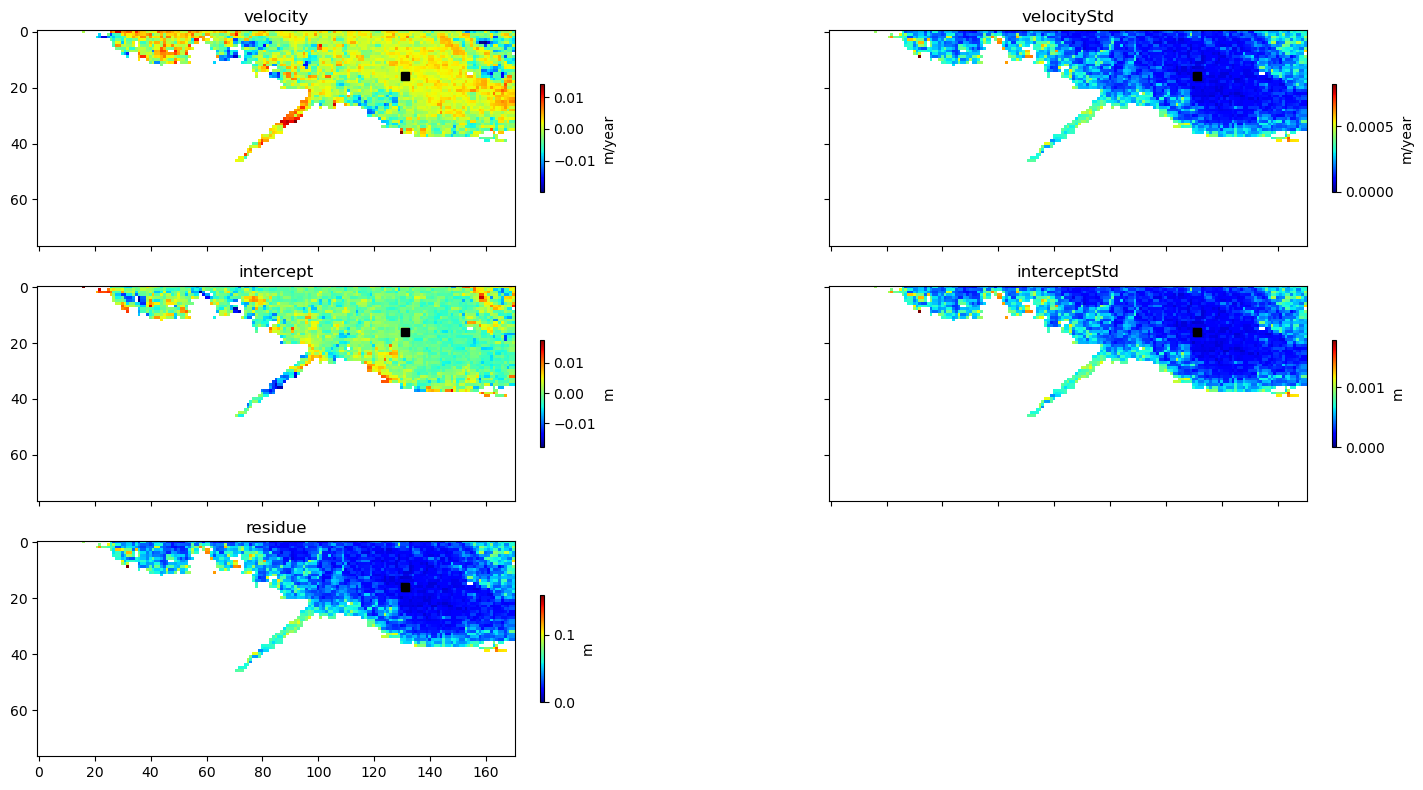

In [36]:
%matplotlib inline
view.main([f'{work_dir}/velocity.h5'])

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

## 5.14. Geocode velocity.h5 in Preparation for Creating a velocity.kmz

**Run the `geocode` step**

- This is unnecessary for geocoded HyP3 data but would be needed for non-geocoded data

In [37]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep geocode

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:52:22.047839--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['geocode']
Remaining steps: ['google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_Little_Belt_Bridge.txt to pic      directory for backup.
copy smallbaselineApp.cfg       to pic      directory for backup.
read default template file: /mnt/d/PhD/PhD_work/

## 5.15. Create a kmz File

**Run the `google_earth` step**

In [38]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep google_earth

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2025-04-05 19:52:31.508036--
Current directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1
Run routine processing with smallbaselineApp.py on steps: ['google_earth']
Remaining steps: ['hdfeos5']
--------------------------------------------------
Project name: Old_Little_Belt_Bridge
Go to work directory: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output
read custom template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/Old_Little_Belt_Bridge.txt
update default template based on input custom template
No new option value found, skip updating /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/smallbaselineApp.cfg
copy Old_Little_Belt_Bridge.txt to inputs   directory for backup.
copy smallbaselineApp.cfg       to inputs   directory for backup.
copy Old_Little_Belt_Bridge.txt to pic      directory for backup.
copy smallbaselineApp.cfg       to pic      directory for backup.
read default template file: /mnt/d/PhD/PhD_work/InSAR/Dmk_b

## 5.16 Plot the unwrapped inverted timeseries

**Create directories in which to store output we will create in upcoming steps**

In [51]:
geotiff_path = work_dir/'GeoTiffs'
geotiff_path.mkdir(exist_ok=True)

disp_path = geotiff_path/'displacement_maps'
disp_path.mkdir(exist_ok=True)

wrapped_path = disp_path/"wrapped"
wrapped_path.mkdir(exist_ok=True)

unwrapped_path = disp_path/"unwrapped"
unwrapped_path.mkdir(exist_ok=True)

demErr = 'timeseries_SET_tropHgt_ramp_demErr.h5'
ts_demErr = work_dir/f'{demErr}'

**Plot the unwrapped inverted time series steps (n, n+1, n+2, etc...)**

- save a png

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is timeseries file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/timeseries_SET_tropHgt_ramp_demErr.h5 in float32 format
file size in y/x: (77, 171)
num of datasets in file timeseries_SET_tropHgt_ramp_demErr.h5: 154
datasets to exclude (0):
[]
datasets to display (154):
['timeseries-20210106', 'timeseries-20210112', 'timeseries-20210118', 'timeseries-20210124', 'timeseries-20210130', 'timeseries-20210205', 'timeseries-20210211', 'timeseries-20210217', 'timeseries-20210223', 'timeseries-20210301', 'timeseries-20210307', 'timeseries-20210313', 'timeseries-20210319', 'timeseries-20210325', 'timeseries-20210331', 'timeseries-20210406', 'timeseries-20210412', 'timeseries-20210418', 'timeseries-20210424', 'timeseries-20210430', 'timeseries-20210506', 'timeseries-20210512', 'timeseries-20210518', 'timeseries-20210524', 'timeseries-20210530', 'timeseries-20210605', 'timeseries-20210611', 'timeseries-20210617', 'timeseries-20

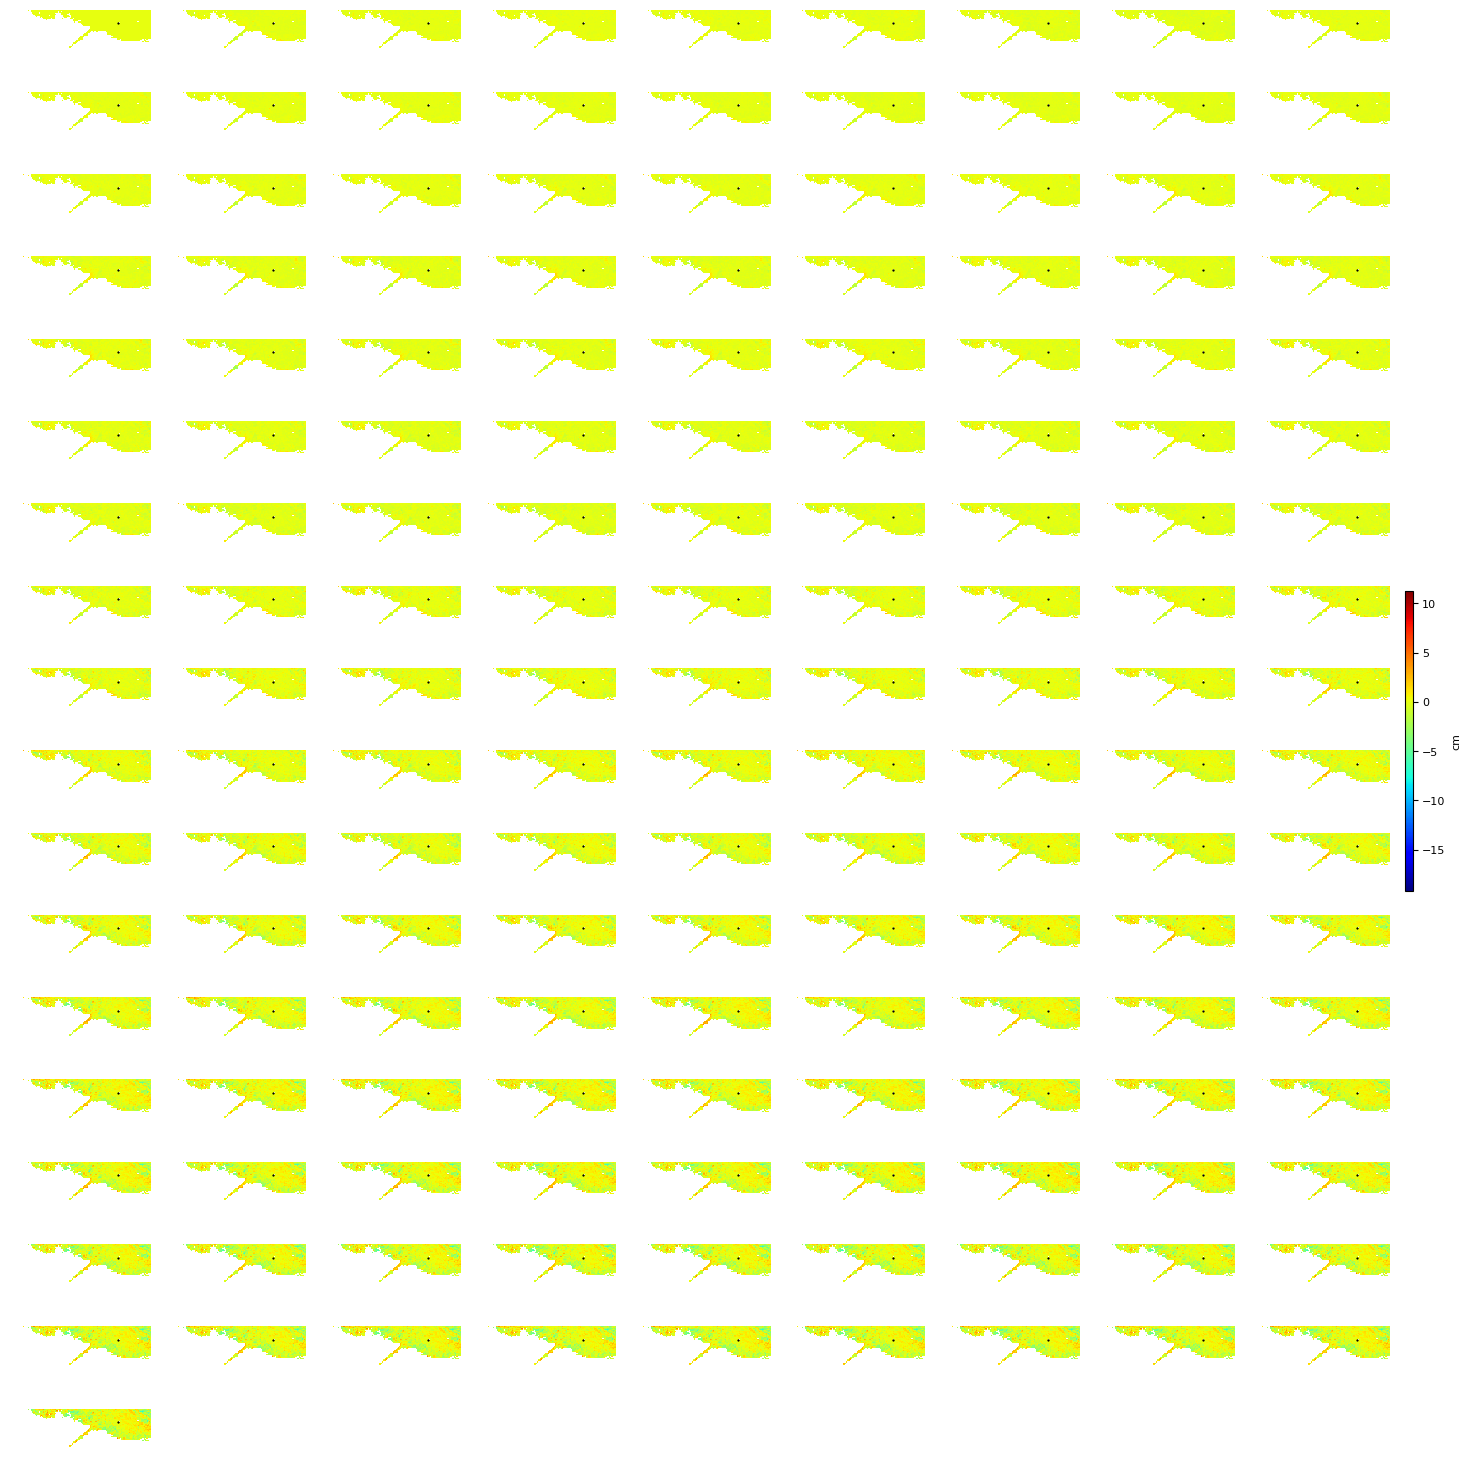

In [52]:
%matplotlib inline
scp_args = f'{ts_demErr} --notitle --notick --noaxis --dpi 600 --figsize 15 15 --outfile {unwrapped_path}/unwrapped_inverted_ts.png'
view.main(scp_args.split())

tsview.py ./output/timeseries_SET_tropHgt_ramp_demErr.h5
open timeseries file: timeseries_SET_tropHgt_ramp_demErr.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 171, 77)
subset coverage in y/x: (0, 0, 171, 77)
data   coverage in lat/lon: (9.68927, 55.526069, 9.731802, 55.507066)
subset coverage in lat/lon: (9.68927, 55.526069, 9.731802, 55.507066)
------------------------------------------------------------------------
reference point in y/x: (16, 131)
reference point in lat/lon: (55.521996928571426, 9.721977356725146)
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
reading timeseries from file ./output/timeseries_SET_tropHgt_ramp_demErr.h5
reference to date: 20210106
read mask from file: maskTempCoh.h5
data    range: [-19.170113, 11.28119] cm
display range: [-19.170113, 11.28119] cm
create figure for m

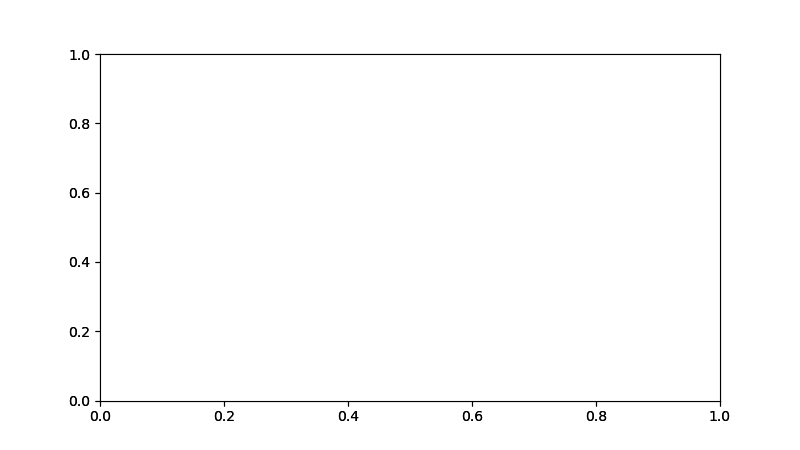

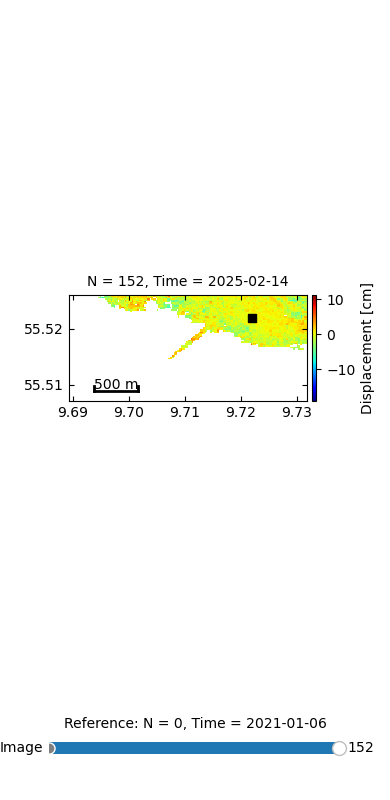

In [54]:
%matplotlib inline
%matplotlib widget
tsview.main(['./output/timeseries_SET_tropHgt_ramp_demErr.h5'])

## 5.17. Saving the Time-series to HDF-EOS5 format
**Run the `hdfeos5` step**

In [ ]:
! smallbaselineApp.py --work-dir {work_dir} {configName} --dostep hdfeos5

# 6. Error analysis (signal vs noise)

Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in MintPy:  

1) During the inversion: 
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise. 
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  


## 6.1. Quality of the inversion

The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation and unwrapping errors. We first show the existing quantities in MintPy to evaluate decorrelation and unwrapping errors and then discuss the existing ways in MintPy to reduce the decorrelation and unwrapping errors on the time-series inversion.

### 6.1.1. Average spatial coherence

Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion.

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is coherence file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/avgSpatialCoh.h5 in float32 format
file size in y/x: (77, 171)
num of datasets in file avgSpatialCoh.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['coherence']
data   coverage in y/x: (0, 0, 171, 77)
subset coverage in y/x: (0, 0, 171, 77)
data   coverage in lat/lon: (9.68927, 55.526069, 9.731802, 55.507066)
subset coverage in lat/lon: (9.68927, 55.526069, 9.731802, 55.507066)
------------------------------------------------------------------------
colormap: gray
figure title: avgSpatialCoh
figure size : [10.0, 3.6]
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.2831615, 0.8811924] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image via matplotlib.pyplot.imshow ...
plot scale bar: [0.2, 0.2, 0.1]
save figure to /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/

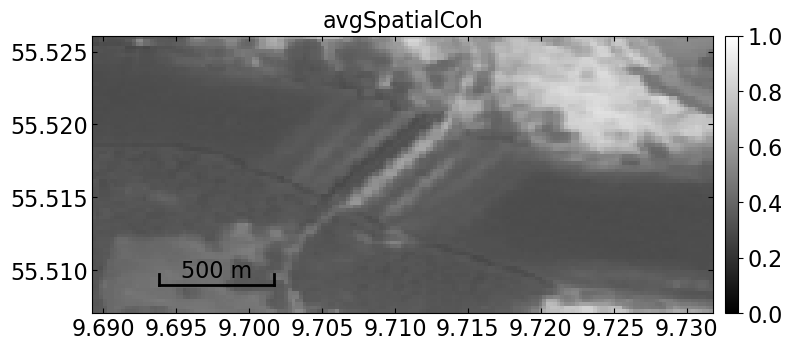

In [56]:
%matplotlib inline
scp_args = f"{work_dir}/avgSpatialCoh.h5 --dpi 600 --outfile {plot_dir}/avg_spatial_coh.png"
view.main(scp_args.split())

### 6.1.2. Temporal coherence

In addition to timeseries.h5 which contains the time-series dataset, invert_network produces other quantities, which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. Temporal coherence represents the consistency of the timeseries with the network of interferograms. 

Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may be used (Yunjun et al, 2019).

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is temporalCoherence file: /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/temporalCoherence.h5 in float32 format
file size in y/x: (77, 171)
num of datasets in file temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['temporalCoherence']
data   coverage in y/x: (0, 0, 171, 77)
subset coverage in y/x: (0, 0, 171, 77)
data   coverage in lat/lon: (9.68927, 55.526069, 9.731802, 55.507066)
subset coverage in lat/lon: (9.68927, 55.526069, 9.731802, 55.507066)
------------------------------------------------------------------------
colormap: gray
figure title: temporalCoherence
figure size : [10.0, 3.6]
reading data ...
masking pixels with NO_DATA_VALUE of 0.0
data    range: [0.0007777421, 1.0] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image via matplotlib.pyplot.imshow ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
save figure t

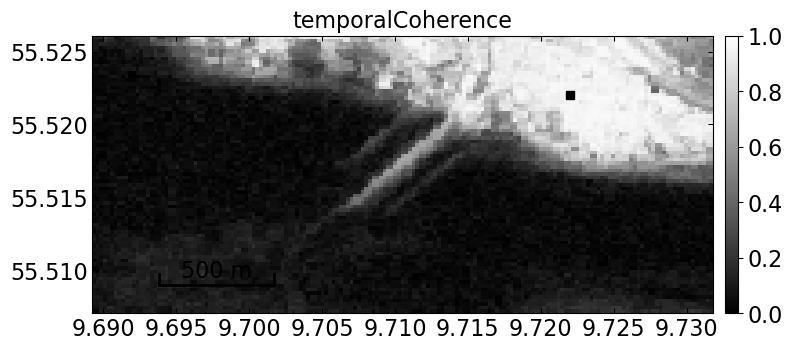

In [57]:
%matplotlib inline
scp_args = f"{work_dir}/temporalCoherence.h5 --dpi 600 --outfile {plot_dir}/temporal_coh.png"
view.main(scp_args.split())

Note that the plot above is the velocity error, not the velocity. The errors generally increases with distance from the reference point and can also increase for points with elevations different from the reference point if topographically correlated water vapor variations are especially strong in the area.

In [40]:
! save_kmz_timeseries.py -h

usage: save_kmz_timeseries.py [-h] [--vel FILE] [--tcoh FILE] [--mask FILE]
                              [-o OUTFILE] [--steps STEPS STEPS STEPS]
                              [--level-of-details LODS LODS LODS LODS]
                              [--vlim VMIN VMAX] [--wrap]
                              [--colormap CMAP_NAME] [--cutoff CUTOFF]
                              [--min-percentage MIN_PERCENTAGE] [--kk]
                              timeseries_file

Generare Google Earth KMZ file for time-series file.

options:
  -h, --help            show this help message and exit
  --kk, --keep-kml, --keep-kml-file
                        Do not remove KML and data/resource files after compressing into KMZ file.

Input files:
  File/Dataset to display

  timeseries_file       Timeseries file to generate KML for
  --vel FILE            Velocity file, used for the color of dot
  --tcoh FILE           temporal coherence file, used for stat info
  --mask FILE           Mask file
  -o OUTFILE,

In [48]:
! save_kmz_timeseries.py ./output/timeseries_SET_tropHgt_ramp_demErr.h5

open timeseries file: timeseries_SET_tropHgt_ramp_demErr.h5
input data shape in row/col: 77/171
writing /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/google_earth_cbar.png
add reference point.
------------------------------
step: 20 pixels
number of output boxes: 1
create KML doc for box 1/1: (0, 0, 171, 77), step: 20 pixels, 24 pixels in total ...
create KML region links directory: 20by20
------------------------------
step: 5 pixels
number of output boxes: 1
create KML doc for box 1/1: (0, 0, 171, 77), step: 5 pixels, 510 pixels in total ...
create KML region links directory: 5by5
------------------------------
get boxes on deforming areas with step: 2 pixels
removing a quadratic phase ramp from input velocity before the evaluation
velocity threshold / median abs dev: 0.010 cm/yr
number of points: 111
number of boxes : 0
create KML region links directory: 2by2
------------------------------
writing /mnt/d/PhD/PhD_work/InSAR/Dmk_bridge_SBAS_1/output/timeseries_SET_tropHgt_ramp_de

In [ ]:
! save_kmz.py ./output/avgSpatialCoh.h5

In [61]:
! save_qgis.py -h

usage: save_qgis.py [-h] -g GEOM_FILE [-o SHP_FILE] [-b Y0 Y1 X0 X1]
                    [-B S N W E] [--zf]
                    ts_file

Convert to QGIS compatible ps time-series

positional arguments:
  ts_file               time-series HDF5 file

options:
  -h, --help            show this help message and exit
  -g GEOM_FILE, --geom GEOM_FILE
                        geometry HDF5 file
  -o SHP_FILE, --outshp SHP_FILE
                        Output shape file.
  -b Y0 Y1 X0 X1, --bbox Y0 Y1 X0 X1
                        bounding box : minLine maxLine minPixel maxPixel
  -B S N W E, --geo-bbox S N W E
                        bounding box in lat lon: South North West East
  --zf, --zero-first    Set displacement at the first acquisition to zero.

example:
  save_qgis.py timeseries_ERA5_ramp_demErr.h5 -g inputs/geometrygeo.h5
  save_qgis.py timeseries_ERA5_ramp_demErr.h5 -g inputs/geometryRadar.h5
  save_qgis.py timeseries_ERA5_ramp_demErr.h5 -g inputs/geometryRadar.h5 -b 200 150 400 35

In [63]:
! save_qgis.py ./output/timeseries_SET_tropHgt_ramp_demErr.h5 -g ./output/inputs/geometryGeo.h5

gather auxliary data files
TimeSeries: ./output/timeseries_SET_tropHgt_ramp_demErr.h5
Velocity  : ./output/velocity.h5
Coherence : ./output/temporalCoherence.h5
Mask      : ./output/maskTempCoh.h5
Geometry  : ./output/inputs/geometryGeo.h5
output shape file: ./output/timeseries_SET_tropHgt_ramp_demErr.shp
number of points with time-series: 3442
[==================================================] line 3443/3442    5s /     0s 
finished writing to file: ./output/timeseries_SET_tropHgt_ramp_demErr.shp


In [ ]:
! view.py -h

In [ ]:
! view.py -d 